# WaveNet

## Waveform Synthesis

In this seminar, we will take a look at DeepMind's [WaveNet](https://arxiv.org/abs/1609.03499) model.

In [1]:
!pip install torchaudio

In [2]:
import math
import pathlib
import random
import itertools
from tqdm import tqdm

from IPython import display
from dataclasses import dataclass

import torch
import torch.nn.functional as F
from torch import distributions
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader

import torchaudio
from torchaudio.transforms import MelSpectrogram

import librosa
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [3]:
# assert torch.__version__.startswith('1.8')
# assert torchaudio.__version__.startswith('0.8')

Let's start by considering the architecture of the network:

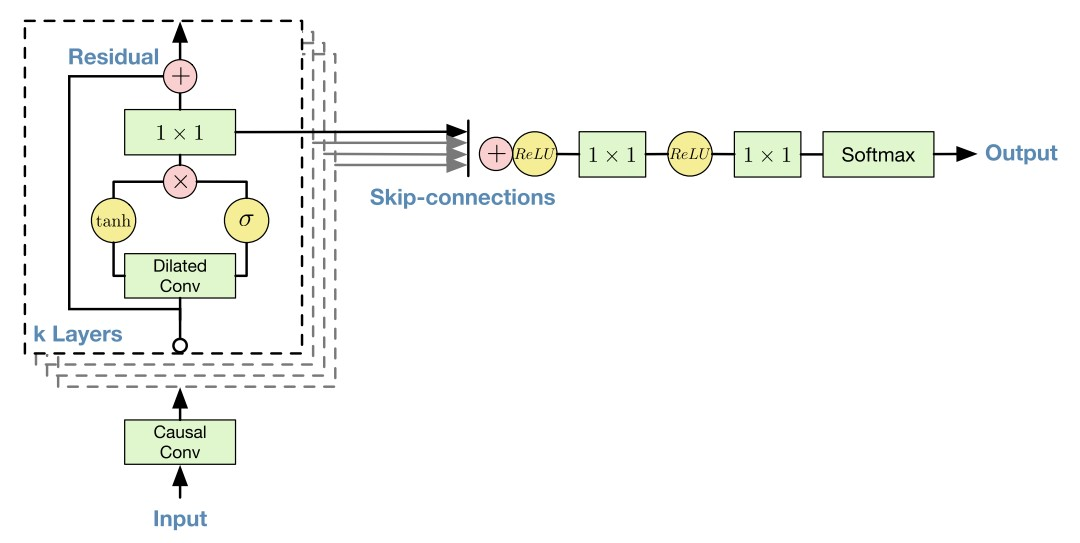



$p(x) = \prod_{t=1}^{T} p(x_t|x_1, ..., x_{t-1})$

Now let's start dealing with the "building blocks" of WaveNet

### Causal Convolutional Layer
The first in turn is **Causal Convolutional Layer**.
The main idea is that with convolutional we do not allow the network to look into the future, i.e. the output of $k$-th layer at time $t$ depends only on the outputs of $k-1$ layer at time $t, t-1, t-2, ..., 1,$ but not at time $t+1, t+2$ and so on.

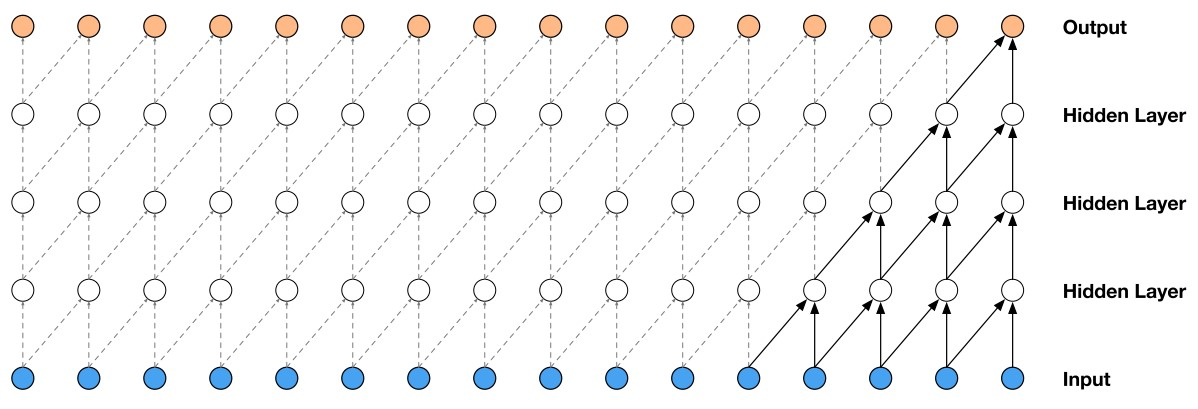

And its variant **Dilated Causal Convolutional Layers**

---



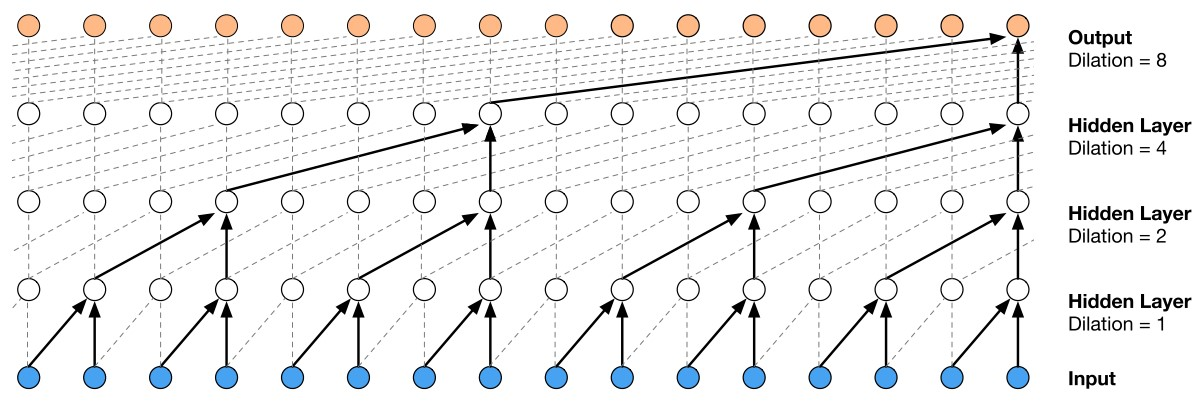

Let's see how this is implemented in code

But first, let's see how it works on a toy example:

#### Simple 1D Convolution

In [4]:
batch_size = 1
in_channel = 1
num_samples = 10

input = torch.arange(num_samples).reshape(batch_size, in_channel, num_samples).float()
print(f'input: {input}')

# Let's omit bias for simplicy
conv_1d = nn.Conv1d(in_channel, in_channel, 3, bias=False)
print(f'weights: {conv_1d.weight}')

# Turn weights into `ones`
nn.init.ones_(conv_1d.weight)

input: tensor([[[0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]]])
weights: Parameter containing:
tensor([[[-0.5694, -0.5303,  0.4103]]], requires_grad=True)


Parameter containing:
tensor([[[1., 1., 1.]]], requires_grad=True)

In [5]:
print(f'Input: {input.squeeze()}')
print(f'After Conv1D: {conv_1d(input).squeeze()}')

Input: tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])
After Conv1D: tensor([ 3.,  6.,  9., 12., 15., 18., 21., 24.], grad_fn=<SqueezeBackward0>)


In [6]:
# Pay attention on the shapes
print(f'Input Shape: {input.size()}')
print(f'After Conv1D Shape: {conv_1d(input).size()}')

Input Shape: torch.Size([1, 1, 10])
After Conv1D Shape: torch.Size([1, 1, 8])


#### Constant 1D Padding

In [7]:
left_padding, right_padding = 2, 3
constant_padding_1d = nn.ConstantPad1d((left_padding, right_padding), value=123)

In [8]:
print(f'Input: {input.squeeze()}')
print(f'After Padding 1D: {constant_padding_1d(input).squeeze()}')

Input: tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])
After Padding 1D: tensor([123., 123.,   0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,
        123., 123., 123.])


In [9]:
# Pay attention on the shapes
print(f'Input Shape: {input.size()}')
print(f'After Padding 1D: {constant_padding_1d(input).size()}')

Input Shape: torch.Size([1, 1, 10])
After Padding 1D: torch.Size([1, 1, 15])


#### Multi channel 1D Convolution

In [10]:
batch_size = 1
in_channel = 10
num_samples = 10

input = torch.arange(in_channel * num_samples).reshape(batch_size, in_channel, num_samples).float()
print(f'input:\n {input}')

# Let's omit bias for simplicy
conv_1d = nn.Conv1d(in_channel, 1, 3, bias=False)
print(f'weights: {conv_1d.weight}')

# Turn weights into `ones`
nn.init.ones_(conv_1d.weight)

input:
 tensor([[[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.],
         [10., 11., 12., 13., 14., 15., 16., 17., 18., 19.],
         [20., 21., 22., 23., 24., 25., 26., 27., 28., 29.],
         [30., 31., 32., 33., 34., 35., 36., 37., 38., 39.],
         [40., 41., 42., 43., 44., 45., 46., 47., 48., 49.],
         [50., 51., 52., 53., 54., 55., 56., 57., 58., 59.],
         [60., 61., 62., 63., 64., 65., 66., 67., 68., 69.],
         [70., 71., 72., 73., 74., 75., 76., 77., 78., 79.],
         [80., 81., 82., 83., 84., 85., 86., 87., 88., 89.],
         [90., 91., 92., 93., 94., 95., 96., 97., 98., 99.]]])
weights: Parameter containing:
tensor([[[ 0.1453, -0.0887,  0.0547],
         [-0.0930, -0.1576, -0.1506],
         [ 0.1788,  0.0879,  0.0037],
         [ 0.0071,  0.0734,  0.0904],
         [-0.0700, -0.1160,  0.0472],
         [ 0.0203, -0.0955,  0.0044],
         [-0.0724,  0.1620, -0.1518],
         [-0.1713,  0.1441,  0.1558],
         [-0.1431,  0.0819, -0.1786],
       

Parameter containing:
tensor([[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]], requires_grad=True)

In [11]:
print(f'Input:\n {input.squeeze()}')
print(f'After Conv1D: {conv_1d(input).squeeze()}')

Input:
 tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.],
        [10., 11., 12., 13., 14., 15., 16., 17., 18., 19.],
        [20., 21., 22., 23., 24., 25., 26., 27., 28., 29.],
        [30., 31., 32., 33., 34., 35., 36., 37., 38., 39.],
        [40., 41., 42., 43., 44., 45., 46., 47., 48., 49.],
        [50., 51., 52., 53., 54., 55., 56., 57., 58., 59.],
        [60., 61., 62., 63., 64., 65., 66., 67., 68., 69.],
        [70., 71., 72., 73., 74., 75., 76., 77., 78., 79.],
        [80., 81., 82., 83., 84., 85., 86., 87., 88., 89.],
        [90., 91., 92., 93., 94., 95., 96., 97., 98., 99.]])
After Conv1D: tensor([1380., 1410., 1440., 1470., 1500., 1530., 1560., 1590.],
       grad_fn=<SqueezeBackward0>)


In [ ]:
class CausalConv1d(nn.Conv1d):
    """
    Casual Conv1d
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int,
        dilation: int = 1,
        bias: bool = True
    ):
        super().__init__(
            in_channels,
            out_channels,
            kernel_size,
            dilation=dilation,
            bias=bias
        )

        padding_size = (kernel_size - 1) * dilation
        self.zero_padding = nn.ConstantPad1d(
            padding=(padding_size, 0),
            value=0.0
        )

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        padded_input = self.zero_padding(input)
        output = super().forward(padded_input)
        return output

In [ ]:
causal_block = CausalConv1d(in_channels=1, out_channels=1, kernel_size=3, dilation=3)

In [ ]:
assert causal_block(input).shape == input.shape

### Gated Activation Units

Now let's turn our attention to this part of the network

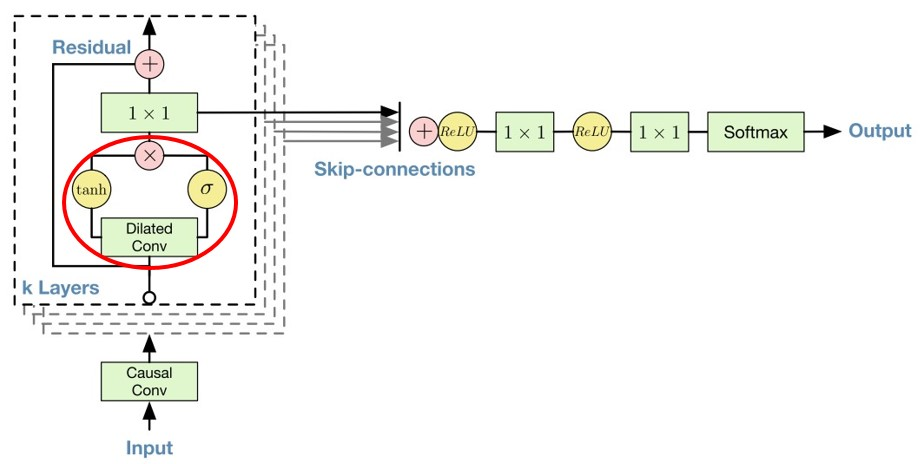

$z = tanh(W_{f,k}*x)\odot\sigma(W_{g,k}*x)$

The authors of the article chose this activation function because it worked better than ReLU in the audio generation experiments.

In [ ]:
class GatedConv1d(nn.Module):
    """
    Gated Conv1d
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int,
        dilation: int
    ):
        super().__init__()

        self.filter_conv = CausalConv1d(in_channels, out_channels, kernel_size, dilation)
        self.gate_conv = CausalConv1d(in_channels, out_channels, kernel_size, dilation)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        filter_ouput = self.filter_conv(input)
        gate_output = self.gate_conv(input)
        
        output = torch.tanh(filter_ouput) * torch.sigmoid(gate_output)

        return output

In [ ]:
gated_conv_block = GatedConv1d(in_channels=1, out_channels=1, kernel_size=3, dilation=3)

In [ ]:
assert gated_conv_block(input).shape == input.shape

By adding an additional input (we get a conditional probability) we can generate sound with certain characteristics. For example, for Text to Speech (TTS) we need to feed **text** or **MelSpectrogram** information as an additional input.

$p(x|h) = \prod_{t=1}^{T} p(x_t|x_1, ..., x_{t-1},h)$

$z = tanh(W_{f,k}*x + V_{f,k}^T *h)\odot\sigma(W_{g,k}*x + V_{g,k}^T *h)$

#### Chunk Function

In [ ]:
print(f'Input: {input.squeeze()}')
print(f'After Chunking: {torch.chunk(input, chunks=2, dim=-1)}')

Input: tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])
After Chunking: (tensor([[[0., 1., 2., 3., 4.]]]), tensor([[[5., 6., 7., 8., 9.]]]))


In [ ]:
class CondGatedConv1d(GatedConv1d):
    """
    Conditioned Gated Conv1d
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        cond_in_channels: int,
        kernel_size: int,
        dilation: int
    ):
        super().__init__(in_channels, out_channels, kernel_size, dilation)

        self.cond_conv = nn.Conv1d(
            in_channels=cond_in_channels,
            out_channels=2 * out_channels,
            kernel_size=1
        )

    def forward(
        self,
        input: torch.Tensor,
        condition: torch.Tensor
    ) -> torch.Tensor:
        assert input.size(-1) == condition.size(-1)
        
        filter_ouput = self.filter_conv(input)
        gate_output = self.gate_conv(input)
        
        c_output = self.cond_conv(condition)
        c_filter_output, c_gate_output = torch.chunk(c_output, 2, dim=1)
        
        output = torch.tanh(filter_ouput + c_filter_output) * torch.sigmoid(gate_output + c_gate_output)

        return output

In [ ]:
conv_gate_conv_block = CondGatedConv1d(
    in_channels=128,
    out_channels=128,
    cond_in_channels=80,
    kernel_size=2,
    dilation=512
)

In [ ]:
dummy_input = torch.randn(32, 128, 100)
cond_input = torch.randn(32, 80, 100)

assert conv_gate_conv_block(dummy_input, cond_input).shape == (32, 128, 100)

### Residual Block

From the blocks already described, let's build a **Residual Block** (or WaveNetBlock).

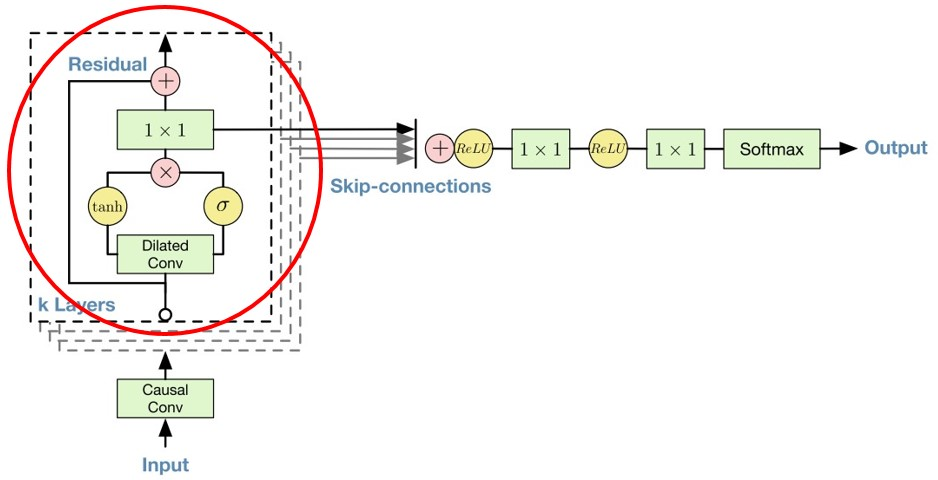

In [ ]:
class CondWaveNetBlock(nn.Module):
    """
    Conditioned WaveNet block
    """

    def __init__(
        self,
        gated_in_channels: int,
        gated_out_channels: int,
        cond_in_channels: int,
        skip_out_channels: int,
        kernel_size: int,
        dilation: int
    ):
        super().__init__()
        
        self.gated_cond = CondGatedConv1d(
            in_channels=gated_in_channels,
            out_channels=gated_out_channels,
            cond_in_channels=cond_in_channels,
            kernel_size=kernel_size,
            dilation=dilation
        )

        self.skip_conv = nn.Conv1d(gated_out_channels, skip_out_channels, kernel_size=1)
        self.residual_conv = nn.Conv1d(gated_out_channels, gated_in_channels, kernel_size=1)
    

    def forward(self, input: torch.Tensor, condition: torch.Tensor) -> torch.Tensor:
        gated_output = self.gated_cond(input, condition)
        
        # y = f(x) + x
        residual_output = self.residual_conv(gated_output) + input
        skip_output = self.skip_conv(gated_output)

        return residual_output, skip_output

### Mu Law

Another important element of architecture is the $\mu$-law.

$f(x_t) = sign(x_t)\frac{ln(1 + \mu |x_t|)}{ln(1 + \mu)}$

Since the raw sound is usually stored as a sequence of 16-bit integer values (one per timestep), the softmax layer will need to output 65,536 (2 ** 16) probabilities on each timestep. Applying the $\mu$-law first and then quantizing to 256 values makes processing easier.

In [ ]:
class MuLaw(nn.Module):

    def __init__(self, mu: float = 256):
        super().__init__()
        self.register_buffer('mu', torch.FloatTensor([mu - 1]))

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return self.encode(input)

    def encode(self, input: torch.Tensor) -> torch.Tensor:
        input = torch.clamp(input, -1 + 1e-5, 1 - 1e-5)

        mu_law_output = torch.sign(input) * \
            torch.log1p(self.mu * torch.abs(input)) / torch.log1p(self.mu)

        # [-1, 1] -> [0, 1]
        quantized_output = (mu_law_output + 1) / 2

        # [0, 1] -> [0, mu - 1]
        quantized_output = torch.floor(quantized_output * self.mu + 0.5).long()
        
        return quantized_output

    def decode(self, input: torch.Tensor) -> torch.Tensor:
        dequantized_output = (input.float() / self.mu) * 2 - 1
        output = (torch.sign(dequantized_output) / self.mu) * \
            ((1 + self.mu) ** torch.abs(dequantized_output) - 1)
        
        return output

In [ ]:
mu_law_encoder = MuLaw(256)

input = torch.randn(5).mul(0.1).clamp(-1, 1)

In [ ]:
print(f'Input: {input}')
print(f'After MuLaw Encoding: {mu_law_encoder(input)}')
print(f'After MuLaw Decoding: {mu_law_encoder.decode(mu_law_encoder(input))}')

Input: tensor([-0.0051, -0.0954, -0.0292,  0.0750,  0.1905])
After MuLaw Encoding: tensor([108,  53,  78, 197, 217])
After MuLaw Decoding: tensor([-0.0052, -0.0962, -0.0298,  0.0767,  0.1884])


### One Hot

In [ ]:
class OneHot(nn.Module):
    """
    Convert quantized 1d samples into n_class one-hot tensor
    """

    def __init__(self, n_class: int = 256):
        super().__init__()

        self.n_class = n_class

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        assert input.dim() == 3, "Expected shape of inout is [B, C, T], where C == 1"
        return self.encode(input)

    def encode(self, input: torch.Tensor) -> torch.Tensor:
        output = torch.zeros(input.size(0), self.n_class, input.size(-1), device=input.device)
        output.scatter_(1, input, 1)
        return output

    def decode(self, input: torch.Tensor) -> torch.Tensor:
        raise NotImplementedError()

### Condition Network

To generate a particular waveform (which contains some specific text), you must condition WaveNet. As a usual rule, WaveNet is conditioned on MelSpectrogram. But there is a little problem, the time dimension of the waveform and MelSpectrogram are different, so it is necessary to align MelSpectrogram with the waveform.

This is usually done by the so-called Condition Network, and it's usually some kind of simple neural network. It consists of either ConvTranspose or Upsample blocks with some non-linearity.

#### Upsample

In [ ]:
upsampling = nn.Upsample(scale_factor=3, mode='nearest')
input = torch.arange(5).view(1, 1, -1).float()

In [ ]:
print(f'Input: {input.squeeze()}')
print(f'After Upsampling: {upsampling(input).squeeze()}')

Input: tensor([0., 1., 2., 3., 4.])
After Upsampling: tensor([0., 0., 0., 1., 1., 1., 2., 2., 2., 3., 3., 3., 4., 4., 4.])


In [ ]:
# Pay attention on the shapes
print(f'Input Shape: {input.size()}')
print(f'After Upsampling Shape: {upsampling(input).size()}')

Input Shape: torch.Size([1, 1, 5])
After Upsampling Shape: torch.Size([1, 1, 15])


In [ ]:
class CondNet(nn.Module):
    """
    Processing condition (mel from TTS or something else)
    """

    def __init__(self, input_size: int, hidden_size: int, hop_size: int):
        """
        :param input_size:
        """
        super().__init__()

        self.input_size = input_size
        self.hop_size = hop_size
        self.hidden_size = hidden_size

        self.net = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size // 2,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
        )
        self.upsampler = nn.Upsample(scale_factor=hop_size, mode='nearest')

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        """
        :return: .shape == [B, T', C']
        """
        
        assert input.shape[-1] == self.input_size

        self.net.flatten_parameters()

        output, _ = self.net(input)

        output = output.transpose(-1, -2)
        upsampled_output = self.upsampler(output)

        return upsampled_output

In [ ]:
condition_net = CondNet(80, 128, 2)
input = torch.randn(1, 100, 80)

In [ ]:
# Pay attention on the shapes
print(f'Input Shape: {input.size()}')
print(f'After Upsampling Shape: {condition_net(input).size()}')

Input Shape: torch.Size([1, 100, 80])
After Upsampling Shape: torch.Size([1, 128, 200])


### WaveNet

In [ ]:
class WaveNet(nn.Module):

    def __init__(
        self,
        # in_channels: int = 256,
        # out_channels: int = 256,
        # gate_channels: int = 512,
        # residual_channels: int = 256,
        # skip_channels: int = 256,
        # head_channels: int = 256,
        # condition_channels: int = 256,
        
        in_channels: int = 64,
        out_channels: int = 64,
        gate_channels: int = 64,
        residual_channels: int = 64,
        skip_channels: int = 64,
        head_channels: int = 64,
        condition_channels: int = 64,
        kernel_size: int = 2,
        dilation_cycles: int = 3,
        dilation_depth: int = 10,
        upsample_factor: int = 480,
    ) -> None:
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.gate_channels = gate_channels
        self.residual_channels = residual_channels
        self.skip_channels = skip_channels
        self.head_channels = head_channels
        self.condition_channels = condition_channels
        self.kernel_size = kernel_size
        self.dilation_cycles = dilation_cycles
        self.dilation_depth = dilation_depth
        self.upsample_factor = upsample_factor

        # 80 -- number of channels in mels 
        self.cond = CondNet(80, self.condition_channels, upsample_factor)

        self.stem = nn.Sequential(
            nn.Conv1d(in_channels, residual_channels, kernel_size=1)
        )

        self.blocks = nn.ModuleList([
            CondWaveNetBlock(residual_channels, gate_channels, condition_channels,
                             skip_channels,
                             kernel_size, 2 ** (i % dilation_depth))
            for i in range(dilation_cycles * dilation_depth)
        ])

        # To avoid DDP error
        self.blocks[-1].residual_conv.requires_grad_(False)

        self.head = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Conv1d(skip_channels, head_channels, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(head_channels, out_channels, kernel_size=1),
        )

    def _forward(self, input: torch.Tensor, condition: torch.Tensor) -> torch.Tensor:
        # already upsampled condition

        stem_output = self.stem(input)

        accumulation = 0
        residual_output = stem_output
        for i, block in enumerate(self.blocks):
            residual_output, skip_output = block(residual_output, condition)
            accumulation = accumulation + skip_output

        output = self.head(accumulation)

        return output

    def forward(self, input: torch.Tensor, condition: torch.Tensor) -> torch.Tensor:
        """
        :param input: samples
        :param condition: mel
        """

        condition = self.cond(condition)
        output = self._forward(input, condition)

        return output

    @property
    def num_parameters(self) -> int:
        return sum([p.numel() for p in self.parameters()])

    @property
    def receptive_field(self) -> int:
        dilations = [2 ** (i % self.dilation_depth)
                     for i in range(self.dilation_cycles * self.dilation_depth)]
        receptive_field = (self.kernel_size - 1) * sum(dilations) + 1

        return receptive_field

    def generate(self, condition: torch.Tensor, inference_type: str = "naive", verbose: bool = True) -> torch.Tensor:
        """
        :param condition: [1, T, C], C from TTS
        :param inference_type:
        :param verbose:
        """

        mu_low = MuLaw().to(condition.device)

        if inference_type == "naive":
            compressed_samples = self._naive_generate(condition, verbose)
        elif inference_type == "fast":
            compressed_samples = self._fast_generate(condition)
        else:
            raise ValueError(f"Invalid type of inference: {inference_type}")

        return mu_low.decode(compressed_samples)

    @torch.no_grad()
    def _naive_generate(self, condition: torch.Tensor, verbose: bool) -> torch.Tensor:
        one_hot = OneHot()

        required_num_samples = condition.shape[1] * self.upsample_factor
        generated_samples = torch.Tensor(1, 1, self.receptive_field + required_num_samples) \
            .fill_(self.in_channels // 2) \
            .to(condition.device)

        condition = self.cond(condition)
        condition = F.pad(condition, (self.receptive_field, 0), 'replicate')

        iterator = range(required_num_samples)
        if verbose:
            iterator = tqdm(iterator)

        for i in iterator:
            current_condition = condition[:, :, i:i + self.receptive_field]
            current_samples = generated_samples[:, :, i:i + self.receptive_field]
            current_one_hot_samples = one_hot(current_samples.long())

            current_output = self._forward(current_one_hot_samples, current_condition)
            last_logits = current_output[:, :, -1].squeeze()

            # sampling new sample
            samples = distributions.Categorical(logits=last_logits)
            new_sample = samples.sample(torch.Size([1]))
            generated_samples[:, :, i + self.receptive_field] = new_sample

        return generated_samples.squeeze()[-required_num_samples:]

In [ ]:
model = WaveNet()

# Data

We will work with the dataset [LJ Speech Dataset] (https://keithito.com/LJ-Speech-Dataset/). The data represents a recording and its transcription. You can listen to examples of recordings at the link.

In [ ]:
# It took 6-7 minutes on Colab
!wget https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2
!tar -xf LJSpeech-1.1.tar.bz2

--2021-11-10 07:51:35--  https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2
Resolving data.keithito.com (data.keithito.com)... 174.138.79.61
Connecting to data.keithito.com (data.keithito.com)|174.138.79.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2748572632 (2.6G) [application/octet-stream]
Saving to: ‘LJSpeech-1.1.tar.bz2’

LJSpeech-1.1.tar.bz 100%[===================>]   2.56G  16.2MB/s    in 2m 51s  

2021-11-10 07:54:27 (15.3 MB/s) - ‘LJSpeech-1.1.tar.bz2’ saved [2748572632/2748572632]



### MelSpectrogram
A class for converting from wav to mel.

In [ ]:
@dataclass
class MelSpectrogramConfig:
    sr: int = 22050
    win_length: int = 1024
    hop_length: int = 256
    n_fft: int = 1024
    f_min: int = 0
    f_max: int = 8000
    n_mels: int = 80
    power: float = 1.0
        
    # value of melspectrograms if we fed a silence into `MelSpectrogram`
    # in case when `min` in clamp is 1e-5
    pad_value: float = -11.5129251


class MelSpectrogram(nn.Module):

    def __init__(self, config: MelSpectrogramConfig):
        super(MelSpectrogram, self).__init__()
        
        self.config = config

        self.mel_spectrogram = torchaudio.transforms.MelSpectrogram(
            sample_rate=config.sr,
            win_length=config.win_length,
            hop_length=config.hop_length,
            n_fft=config.n_fft,
            f_min=config.f_min,
            f_max=config.f_max,
            n_mels=config.n_mels
        )

        self.mel_spectrogram.spectrogram.power = config.power

        # Default `torchaudio` mel basis uses HTK formula. So we decided to
        # use Slaney one instead (as well as `librosa` does by default).
        mel_basis = librosa.filters.mel(
            sr=config.sr,
            n_fft=config.n_fft,
            n_mels=config.n_mels,
            fmin=config.f_min,
            fmax=config.f_max
        ).T
        self.mel_spectrogram.mel_scale.fb.copy_(torch.tensor(mel_basis))
    

    def forward(self, audio: torch.Tensor) -> torch.Tensor:
        """
        :param audio: Expected shape is [B, T]
        :return: Shape is [B, n_mels, T']
        """
        
        mel = self.mel_spectrogram(audio) \
            .clamp_(min=1e-5) \
            .log_()

        return mel

In [ ]:
mel_spectrogramer = MelSpectrogram(MelSpectrogramConfig())

In [ ]:
wav, sr = torchaudio.load('./LJSpeech-1.1/wavs/LJ001-0001.wav')
gt_spec = mel_spectrogramer(wav)

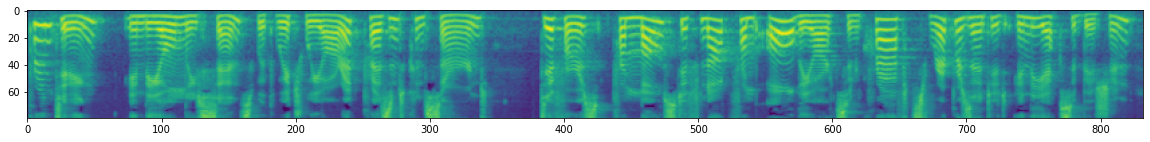

In [ ]:
plt.figure(figsize=(20, 5))
plt.imshow(gt_spec.squeeze())

In [ ]:
mel_spectrogramer(wav[:, :1024]).shape

torch.Size([1, 80, 5])

### LJSpeech Dataset

Define a class for the dataset.

In [ ]:
# !ls LJSpeech-1.1/wavs

In [ ]:
class LJSpeech(Dataset):
    def __init__(
        self,
        path2csv: str,
        mel_spec_config: MelSpectrogramConfig,
        dataset_root: str = './LJSpeech-1.1',
        max_time_samples: int = 256 * 76,
        train: bool = True
    ):
        super().__init__()
        self.path2csv = path2csv
        self.mel_spec_config = mel_spec_config
        self.dataset_root = pathlib.Path(dataset_root)
        self.max_time_samples = max_time_samples
        self.train = train

        self.featurizer = MelSpectrogram(mel_spec_config)

        df = pd.read_csv(
            path2csv,
            names=['id', 'gt', 'gt_letters_only'],
            sep="|"
        )
        df = df.dropna()

        self.names = list(df['id'])
    
    def __len__(self):
        return len(self.names)
    
    def __getitem__(self, idx):
        wav, sr = torchaudio.load(self.dataset_root / f'wavs/{self.names[idx]}.wav')
        wav.squeeze_()

        if self.train:
            # crop wav to `self.sample_per_wav` size
            start_sample = random.randint(0, wav.size(-1) - self.max_time_samples)
            wav = wav[start_sample:start_sample + self.max_time_samples]

        return wav

In [ ]:
train_dataset = LJSpeech(
    '/content/LJSpeech-1.1/metadata.csv',
    MelSpectrogramConfig(),
    max_time_samples=256 * 76,
)
train_dataloader = DataLoader(train_dataset, batch_size=2, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Train

In [ ]:
class AverageMeter:
    
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
# just to know
BATCH, CHANNEL, TIME = 0, 1, 2

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = WaveNet(
    in_channels=256,
    out_channels=256,
    condition_channels=80,
    upsample_factor=256
).to(device)

mu_law = MuLaw(256).to(device)
one_hot = OneHot(256).to(device)
mel_specer = MelSpectrogram(MelSpectrogramConfig()).to(device)
    
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss().to(device)

In [ ]:
train_loss = []

In [ ]:
num_epoch = 1

for epoch in range(num_epoch):

    train_epoch_loss = AverageMeter()

    model.train()
    for i, samples in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        # global_step = epoch * len(train_dataloader) + i
        optimizer.zero_grad()

        samples = samples.to(device)
        # crop mels since mel_specer produce reduntant padding
        mels = mel_specer(samples)[..., :-1]
        
        categorical_samples = mu_law(samples).unsqueeze(dim=1)
        one_hot_samples = one_hot(categorical_samples)
        prediction = model(one_hot_samples, mels.transpose(-1, -2))
        
        loss = criterion(prediction[:, :, :-1],
                         categorical_samples.squeeze(dim=1)[:, 1:])
        loss.backward()
        
        optimizer.step()
        
        # Print loss
        if i % 50 == 0:
            train_epoch_loss.update(loss.item())
            print("Loss: ", loss.item())

    train_loss.append(train_epoch_loss.avg)
    
    display.clear_output()
    plt.plot(train_loss)
    plt.grid()
    plt.show()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0%|          | 1/6542 [00:00<1:13:03,  1.49it/s]

Loss:  5.548309326171875


  1%|          | 51/6542 [00:27<57:26,  1.88it/s]

Loss:  4.89367151260376


  2%|▏         | 101/6542 [00:53<56:36,  1.90it/s]

Loss:  4.2042036056518555


  2%|▏         | 151/6542 [01:19<56:23,  1.89it/s]

Loss:  3.9287145137786865


  3%|▎         | 201/6542 [01:46<56:04,  1.88it/s]

Loss:  3.939331531524658


  4%|▍         | 251/6542 [02:13<56:08,  1.87it/s]

Loss:  3.4428086280822754


  5%|▍         | 301/6542 [02:39<55:06,  1.89it/s]

Loss:  3.1830735206604004


  5%|▌         | 351/6542 [03:06<54:59,  1.88it/s]

Loss:  3.213444471359253


  6%|▌         | 401/6542 [03:32<54:05,  1.89it/s]

Loss:  3.236828088760376


  7%|▋         | 451/6542 [03:59<53:54,  1.88it/s]

Loss:  3.0635130405426025


  8%|▊         | 501/6542 [04:26<53:31,  1.88it/s]

Loss:  3.033799886703491


  8%|▊         | 551/6542 [04:52<53:19,  1.87it/s]

Loss:  3.0234415531158447


  9%|▉         | 601/6542 [05:19<52:34,  1.88it/s]

Loss:  3.3633720874786377


 10%|▉         | 651/6542 [05:46<52:14,  1.88it/s]

Loss:  3.253056764602661


 11%|█         | 701/6542 [06:12<51:48,  1.88it/s]

Loss:  2.7469964027404785


 11%|█▏        | 751/6542 [06:39<52:08,  1.85it/s]

Loss:  2.6965670585632324


 12%|█▏        | 801/6542 [07:06<50:48,  1.88it/s]

Loss:  3.0318682193756104


 13%|█▎        | 851/6542 [07:32<50:50,  1.87it/s]

Loss:  3.0131592750549316


 14%|█▍        | 901/6542 [07:59<49:53,  1.88it/s]

Loss:  2.847878932952881


 15%|█▍        | 951/6542 [08:25<49:48,  1.87it/s]

Loss:  2.757902145385742


 15%|█▌        | 1001/6542 [08:52<49:41,  1.86it/s]

Loss:  3.164147138595581


 16%|█▌        | 1051/6542 [09:19<49:05,  1.86it/s]

Loss:  2.6340208053588867


 17%|█▋        | 1101/6542 [09:45<48:06,  1.88it/s]

Loss:  2.8157098293304443


 18%|█▊        | 1151/6542 [10:12<48:03,  1.87it/s]

Loss:  2.966118812561035


 18%|█▊        | 1181/6542 [10:28<47:34,  1.88it/s]


KeyboardInterrupt: ignored

In [ ]:
# Yes, it is the same dataset but it does not matter now
validation_dataset = LJSpeech(
    '/content/LJSpeech-1.1/metadata.csv',
    MelSpectrogramConfig(),
    max_time_samples=256 * 76,
    train=False
)

In [ ]:
val_wav = validation_dataset[0]

In [ ]:
val_mel = mel_spectrogramer(val_wav)

In [ ]:
val_mel.shape

torch.Size([80, 832])

In [ ]:
# 160 mels ~= 2 sec
generated_val_wav = model.generate(val_mel[..., :5].unsqueeze(0).transpose(-1, -2).to(device))

100%|██████████| 1280/1280 [00:34<00:00, 36.92it/s]


In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['display', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


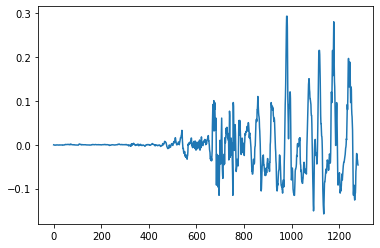

In [ ]:
plt.plot(generated_val_wav.cpu())

In [ ]:
generated_val_wav.cpu()

tensor([-8.6212e-05, -2.6436e-04, -4.5043e-04,  ..., -3.6255e-02,
        -4.3890e-02, -4.6015e-02])

In [ ]:
from IPython import display

In [ ]:
# Bad quality but it works!
# For better quality you need bigger model and 3-4 days of training :)
display.Audio(generated_val_wav.cpu(), rate=22050)